## Shocks to Inflation

This notebook constructs all shocks to inflation used to explore conditional responses of inflation expectations

- Oil shocks: Hamilton (1996) （no need for SVAR)
- Technology shocks: Gali(1999) and Francis et al.(2014)
- News shocks: Sims et al.(2014)
- Monetary policy shocks: unexpected funds rate change and future change (reference to be added)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
from numpy import linalg as LA
import statsmodels.api as sm

## tools var available in statsmodels 
from statsmodels.tsa.api import VAR, SVAR
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from statsmodels.tsa.vector_ar.irf import BaseIRAnalysis
from statsmodels.tsa.base.datetools import dates_from_str
import statsmodels.tsa.vector_ar.plotting as plotting
import statsmodels.tsa.vector_ar.util as util
from scipy.stats import pearsonr as prs
from scipy.optimize import minimize

In [2]:
## loading technology shock data 
import pandas_datareader.data as web
import datetime as dt

### download other macroeconomic data series and merge it with the aggregate uncertainty 

sdt = dt.datetime(1945, 1, 1)
edt = dt.datetime(2022, 6,30)

### Oil shocks (Hamilton 1996)

In [3]:
os_dataM = web.DataReader(['WTISPLC'], 
                          'fred', 
                          sdt,
                          edt)
os_dataM = os_dataM.rename(columns = {'WTISPLC':'op'})
os_dataM['lop'] = np.log(os_dataM['op'])
os_dataM['os_max_l12'] = os_dataM['lop'].shift(1).rolling(12).max()
os_dataM['os_2_max_l12'] = os_dataM['op']-os_dataM['os_max_l12']
os_dataM['OPShock'] =  os_dataM['os_2_max_l12']* (os_dataM['os_2_max_l12']>0.0)
os_dataM = os_dataM[['lop','OPShock']]

## normolization using std 

os_dataM['OPShock_nm'] =  os_dataM['OPShock']/os_dataM['OPShock'].std()

os_datesM =  os_dataM.index.year.astype(int).astype(str) + \
         "M" + os_dataM.index.month.astype(int).astype(str)
os_datesM = dates_from_str(os_datesM)

## save a monthly version 
os_M = pd.DataFrame(os_dataM['OPShock_nm'].copy())
os_M.columns=(['OPShock_nm'])
os_M.index = pd.DatetimeIndex(os_datesM)

## compute quarterly shock

os_dataM['quarter'] = os_dataM.index.year.astype(int).astype(str) + \
         "Q" + os_dataM.index.quarter.astype(int).astype(str)

os_shockQ  = os_dataM.groupby(['quarter'], sort=False)['OPShock_nm'].max()

## creating quarterly date 

os_datesQ = os_dataM['quarter'].drop_duplicates()
os_datesQ = dates_from_str(os_datesQ)

## prepare quarterly series 
os_shockQ.columns=(['OPShock_nm'])
os_shockQ.index = pd.DatetimeIndex(os_datesQ,freq='Q')


In [4]:
## loading oil price shocks data 
os_dataM = pd.read_excel('../OtherData/OilShock.xls',sheet_name='data')

## dates 
os_dataM['observation_date'] = pd.to_datetime(os_dataM['observation_date'],format='%Y%m%d')
os_dataM['quarter'] = os_dataM['observation_date'].dt.year.astype(int).astype(str) + \
         "Q" + os_dataM['observation_date'].dt.quarter.astype(int).astype(str)

## normolization using std 

os_dataM['OPShock_nm'] =  os_dataM['OPShock']/os_dataM['OPShock'].std()

## compute quarterly shock
os_shockQ  = os_dataM.groupby(['quarter'], sort=False)['OPShock_nm'].max()

## creating quarterly date 
os_dateM =  os_dataM['observation_date'].dt.year.astype(int).astype(str) + \
         "M" + os_dataM['observation_date'].dt.month.astype(int).astype(str)
os_datesM = dates_from_str(os_dateM)
os_datesQ = os_dataM['quarter'].drop_duplicates()
os_datesQ = dates_from_str(os_datesQ)

## prepare quarterly series 
os_shockQ.index = pd.DatetimeIndex(os_datesQ,freq='Q')

## save a monthly version 
os_M = pd.DataFrame(os_dataM['OPShock_nm'].copy())
os_M.columns=(['OPShock_nm'])
os_M.index = pd.DatetimeIndex(os_datesM)


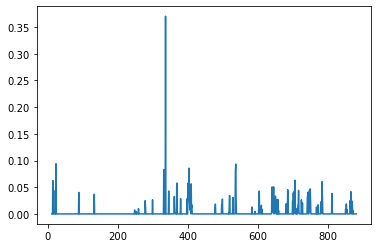

In [5]:
plt.plot(os_dataM['OPShock'])

### Monetary policy shocks 

In [6]:
## loading mp shocks data 
mps_data = pd.read_excel('../OtherData/2MPShocksJW.xls',sheet_name='data')
mps_data['Date'] = pd.to_datetime(mps_data['Date'],format='%m/%d/%Y')
mps_datesQ = mps_data['Date'].dt.year.astype(int).astype(str) + \
         "Q" + mps_data['Date'].dt.quarter.astype(int).astype(str)

## quarter series used to collapse 
mps_datesQ = dates_from_str(mps_datesQ)
mps_data['quarter'] = mps_datesQ 

mps_var = mps_data[['quarter','MP1','ED4','ED8']] 

## dates 
mps_datesM = mps_data['Date'].dt.year.astype(int).astype(str) + \
         "M" + mps_data['Date'].dt.month.astype(int).astype(str)
mps_datesM = dates_from_str(mps_datesM)

## monthly index 
mps_var.index = pd.DatetimeIndex(mps_datesM)
mps_var = mps_var.replace('.',0.0)

## convert types 
mps_var['MP1']=pd.to_numeric(mps_var['MP1'],errors='coerce')   
mps_var['ED4']=pd.to_numeric(mps_var['ED4'],errors='coerce')   
mps_var['ED8']=pd.to_numeric(mps_var['ED8'],errors='coerce')  


In [7]:
# multiple times of monetary policy within some quarters. Thus cumulative sum is taken as the shock of that quarter

mps_shockQ  = mps_var.groupby(['quarter'], sort=False).sum()
 
## convert to numeric 

mps_shockQ['MP1']=pd.to_numeric(mps_shockQ['MP1'],errors='coerce')   
mps_shockQ['ED4']=pd.to_numeric(mps_shockQ['ED4'],errors='coerce')   
mps_shockQ['ED8']=pd.to_numeric(mps_shockQ['ED8'],errors='coerce')

## frequence 

mps_shockQ = mps_shockQ.asfreq('Q')

In [8]:
mps_shockQ

,MP1,ED4,ED8
quarter,,,
1984-03-31,0.00000,-0.020,0.000
1984-06-30,0.00000,0.050,0.000
1984-09-30,0.00000,0.020,0.000
1984-12-31,0.00000,-0.540,0.000
1985-03-31,0.00000,-0.090,0.000
...,...,...,...
2018-03-31,-0.00500,0.005,0.035
2018-06-30,-0.00442,0.025,0.025
2018-09-30,0.01069,0.015,0.015


### Tech shocks identified using Max-share of forecast error (Francis et al.(2014)) 

Francis et al.(2014) identified technoogy shocks in an approach shown to have less small-sample-bais than long-run restrictions. I also identify tech shocks in their approach. (Also, the news shock is identified in a very similar approach, see below.)

Again, the structural VAR can written as the following 


$$y_t =C(L)\epsilon_t = A^{-1}(L)B \epsilon_t = A^{-1}(L) u_t = D(L)u_t$$

where $y_t = [ \Delta x_t,  \Delta n_t, \pi_t  ]'$.

h-period-ahead forecast error 

$$y_{t+h}- \hat y_{t+h}= \sum^{h-1}_{\tau=0} D_\tau u_{t+h-\tau} $$

Let us assume an othogonal matrix $F$ (i.e. $F'F=I$), then we have 

$$y_{t+h}- \hat y_{t+h} = \sum^{h-1}_{\tau=0} D_\tau FF' u_{t+h-\tau}$$

The h-period-ahead variance share for a particular variable i attributed to $j$ shock is 

$$\omega_{ij}(h) = \frac{e_i' [\sum^{\tau=h-1}_{\tau=0} D_\tau \alpha \alpha' D_\tau'] e_i}{e_i' [\sum^{\tau=h-1}_{\tau=0} D_\tau \Omega_u D_\tau'] e_i }$$

where $\alpha = F e_j$, the $j$-th column of F, and $e_i$ is a $n \times 1$ vector that picks responses of $i$. 

For an exogeously chosen $h$, the technology shock is identified by solving the following problem

$$\underset{\alpha}{\text{max}}\quad \omega_{1j}(\alpha(h)) = \frac{e_i' [\sum^{\tau=h-1}_{\tau=0} D_\tau \alpha \alpha' D_\tau'] e_i}{e_i' [\sum^{\tau=h-1}_{\tau=0} D_\tau \Omega_u D_\tau'] e_i }$$

Once we can solve $\alpha$, we can compute the identified tech shock as 

$$\epsilon^z_t = \alpha H^{-1}u^z_t  $$

and $$H=chol(\Omega_u)$$

### Tech shocks identified via SVAR with long-run restrictions (Gali (1999))

A vector of variables: $\Delta x_t$, $\Delta n_t$ and $\pi_t$

$$\left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] = \left[\begin{array} \\ C(L)_{11}, C(L)_{12}, C(L)_{13} \\ C(L)_{21}, C(L)_{22}, C(L)_{23} \\ C(L)_{31}, C(L)_{32}, C(L)_{33} \end{array}  \right]   \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

Identification restriction is 

- Orthogonality + normalization: $E(\epsilon \epsilon')= I$   
- $C(1)_{12}=0$
- $C(1)_{13}=0$
- $C(1)_{23}=0$

Then $C(L)$ is lower triangluar and just identified. This is so called long-run restrictions from Blanchard and Quah (1989). 

Rewriting it into a general form of SVAR, we have  

$$A(L) \left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] =\left[\begin{array} \\ u_t^z \\ u^m_t \\ u^\pi_t  \end{array}\right]  =B \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

where $u_t$ is reduced form residul and $\epsilon_t$ is structural shock. 


$$\left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] =A(L)^{-1} B \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] = \mathbf{C}(L) \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

With $p$ lags, we have $$A(L) = I_k - A_1L - A_2L^2-\ldots - A_pL^p$$

The estimation takes following steps. 

1. Estimate OLS to get estimates $\hat A_1, \hat A_2, \ldots, \hat A_p$ and $\hat \Sigma^u$.

2. Use the following to sovle $\hat B$, $$\underbrace{(I_k - \hat A_1 - \ldots - \hat A_p)^{-1}}_{\hat A(1)} \hat B = Col((I_k - \hat A_1 - \ldots - \hat A_p)\hat \Sigma^u(I_k - \hat A'_1 - \ldots - \hat A'_p)^{-1})$$ 

The existing SVAR package in *statsmodels* only handles cases with direct zero restrictions on $B$ matrices. Therefore I write my own codes using long-run restrictions here.  

In [9]:


macro_time_series_M = web.DataReader(['NPPTTL'], ## Total Nonfarm Private Payroll Employment, Thousands, Quarterly, Seasonally Adjusted
                                     'fred', 
                                     sdt, 
                                     edt)

macro_time_series_Q = web.DataReader(["HOANBS",        ## Nonfarm Business Sector: Hours of All Persons, Index 2012=100, Quarterly, Seasonally Adjusted 
                                      "GDPC1"],      ## Real Gross Domestic Product, Billions of Chained 2012 Dollars, Quarterly, Seasonally Adjusted Annual Rate
                                     'fred',
                                     sdt,
                                     edt)

macro_time_series_M.index = pd.to_datetime(macro_time_series_M.index)

macro_time_series_M = macro_time_series_M.resample('Q').mean()
macro_time_series_M.index = macro_time_series_M.index.shift(1,freq='D')

macro_time_series_Q = pd.merge(macro_time_series_M,
                              macro_time_series_Q,
                              left_index = True,
                              right_index = True)

In [10]:
macro_time_series_M.head(20)

,NPPTTL
DATE,
2002-07-01,108983.692667
2002-10-01,108723.591000
2003-01-01,108550.879000
2003-04-01,108558.815000
2003-07-01,108606.483333
2003-10-01,108612.242333
2004-01-01,108984.404667
2004-04-01,109260.184333
2004-07-01,109929.131000


In [12]:
## loading technology shock data
ts_data = pd.read_excel('../OtherData/Emp.xls',sheet_name='data')
ts_data2 = pd.read_excel('../OtherData/EmpSaQ.xls',sheet_name='data')
#ts_data['observation_date'] = pd.to_datetime(ts_data['observation_date'],format='%Y%m%d')
#ts_data2['observation_date'] = pd.to_datetime(ts_data['observation_date'],format='%Y%m%d')


## streamline the dates in correct formats
datesQ1 = ts_data['observation_date'].dt.year.astype(int).astype(str) + \
         "Q" + ts_data['observation_date'].dt.quarter.astype(int).astype(str)
datesQ1 = dates_from_str(datesQ1)

datesQ2 = ts_data2['observation_date'].dt.year.astype(int).astype(str) + \
         "Q" + ts_data['observation_date'].dt.quarter.astype(int).astype(str)
datesQ2 = dates_from_str(datesQ2)

## loading inflation data and converting from monthly to quarterly
inf_dataM = pd.read_stata('../OtherData/InfM.dta')
filterQ = inf_dataM['month'].isin([3,6,9,12])
inf_dataQ = inf_dataM[filterQ]
infQ = inf_dataQ['CPIAU'].pct_change()

inf_datesQ = inf_dataQ['date'].dt.year.astype(int).astype(str) + \
             "Q" + inf_dataQ['date'].dt.quarter.astype(int).astype(str)
inf_datesQ = dates_from_str(inf_datesQ)

## Other inflation measurs as backup

infQ_all = inf_dataQ[['CPIAU','CPICore','PCE']].pct_change()

In [13]:
# set date index to productivity and labor series
ts_var1 = ts_data[['DLPROD1','DLHOURS']]
ts_var2 = ts_data2[['DLPROD2','DLEMP']]

ts_var1.index = pd.DatetimeIndex(datesQ1,freq='Q')
ts_var2.index = pd.DatetimeIndex(datesQ2,freq='Q')

# set date index to inf series 
infQ.index = pd.DatetimeIndex(inf_datesQ)
infQ_all.index = pd.DatetimeIndex(inf_datesQ)
infQ_all.columns=['CPIAU','CoreCPI','PCE']

In [14]:
## merge with inflation

### include all inflation measures
LRVar_dt = pd.concat([ts_var1,infQ_all],join='inner',axis=1)

# order of vector for var:  [productivity, labor input, inflation]
ts_var1 = pd.concat([ts_var1,infQ], join='inner', axis=1)
ts_var2 = pd.concat([ts_var2,infQ], join='inner', axis=1)

ts_var1=ts_var1.copy().dropna()
ts_var2=ts_var2.copy().dropna()

## save the data for stata use

LRVar_dt['year'] = LRVar_dt.index.year
LRVar_dt['quarter'] = LRVar_dt.index.quarter
LRVar_dt.to_stata('../OtherData/LRVar.dta')

In [15]:
# period filter 
start_t='1948-01-01'
end_t = '2019-03-30'   # the same period as in Gali (1991)

ts_var1=ts_var1.copy().loc[start_t:end_t]
ts_var2=ts_var2.copy().loc[start_t:end_t]

# Estimate reduced VAR 
model1 = VAR(ts_var1)  # var model with no restriction
model2 =VAR(ts_var2)   # var model2 with no restriction

#svmodel1=SVAR(ts_var1.loc[start_t:end_t],svar_type='B',\
 #             B=np.array([['E',0,0],['E','E',0],['E','E','E']]))  # svar model with restriction
#svmodel2=SVAR(ts_var2.loc[start_t:end_t],svar_type='B',\
              # B=np.array([['E',0],['E','E']]))  # svar model with restriction

In [16]:
## Checks the data 

## Pearson test of correlation 
prs1_pval=prs(ts_var1.iloc[:,0],ts_var1.iloc[:,1])[1]
prs2_pval=prs(ts_var2.iloc[:,0],ts_var2.iloc[:,1])[1]

print('Model1: using total non-farm hours as labor inputs measure')
print('Sample mean:\n'+str(ts_var1.mean()))
print('Correlation coefficients of series\n'+str(ts_var1.corr()))
print('The p-value of Pearson Test on the correlation of productivity and labor input is '+str(round(prs1_pval,3)))

print('Model2: using civil employment as labor inputs measure')
print('Sample mean:\n'+str(ts_var2.mean()))
print('Correlation coefficients of series\n'+str(ts_var2.corr()))
if prs2_pval !='NaN':
    print('The p-value of Pearson Test on the correlation of productivity and labor input is '+str(round(prs2_pval,3)))

Model1: using total non-farm hours as labor inputs measure
Sample mean:
DLPROD1    0.002044
DLHOURS    0.001339
CPIAU      0.008445
dtype: float64
Correlation coefficients of series
          DLPROD1   DLHOURS     CPIAU
DLPROD1  1.000000 -0.314017 -0.174047
DLHOURS -0.314017  1.000000  0.124158
CPIAU   -0.174047  0.124158  1.000000
The p-value of Pearson Test on the correlation of productivity and labor input is 0.0
Model2: using civil employment as labor inputs measure
Sample mean:
DLPROD2    0.001845
DLEMP      0.001527
CPIAU      0.008462
dtype: float64
Correlation coefficients of series
          DLPROD2     DLEMP     CPIAU
DLPROD2  1.000000 -0.024642 -0.106352
DLEMP   -0.024642  1.000000  0.144149
CPIAU   -0.106352  0.144149  1.000000
The p-value of Pearson Test on the correlation of productivity and labor input is 0.68


In [17]:
rs1=model1.fit(4)
#rs1=model1.fit(ic='bic')
#rs2=model2.fit(ic='bic')
#srs1=svmodel1.fit(4)
#srs2=svmodel2.fit(4,solver='nm')

In [18]:
rs1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, May, 2023
Time:                     15:15:21
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -33.0712
Nobs:                     280.000    HQIC:                  -33.3744
Log likelihood:           3547.94    FPE:                2.61560e-15
AIC:                     -33.5775    Det(Omega_mle):     2.28267e-15
--------------------------------------------------------------------
Results for equation DLPROD1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.002473         0.000431            5.742           0.000
L1.DLPROD1        -0.079011         0.062492           -1.264           0.206
L1.DLHOURS        -0.123573         0.059786           -2.067         

In [19]:
## define function of Blanchard and Quah long-run restriction

def ma_rep(coefs, maxn=10):
    """
    MA(\infty) representation of VAR(p) process
    Parameters
    ----------
    coefs : ndarray (p x k x k)
    maxn : int
        Number of MA matrices to compute
    Notes
    -----
    VAR(p) process as
    .. math:: y_t = A_1 y_{t-1} + \ldots + A_p y_{t-p} + u_t
    can be equivalently represented as
    .. math:: y_t = \mu + \sum_{i=0}^\infty \Phi_i u_{t-i}
    e.g. can recursively compute the \Phi_i matrices with \Phi_0 = I_k
    Returns
    -------
    phis : ndarray (maxn + 1 x k x k)
    """
    p, k, k = coefs.shape
    phis = np.zeros((maxn+1, k, k))
    phis[0] = np.eye(k)
    # recursively compute Phi matrices
    for i in range(1, maxn + 1):
        for j in range(1, i+1):
            if j > p:
                break
                
            phis[i] += np.dot(phis[i-j], coefs[j-1])
    return phis


def SVAR_BQLR(rs,T_irf=10):
    """
    Parameters
    ------
    rs: result object of reduced VAR estimated using statsmodels.tsa.VAR
    
    Returns
    -------
    dictionary:
      sigma_u: ndarrray
               variance-convariance of reduced VAR residuals 
      B_est:   ndarray
               estimated B matrices using long-run restrictions
      eps_est: ndarray
               estimated structural shocks
      A_L:     ndarray
               I_k - A_1 - \ldots -A_p
      C_L:     adarray 
               A_L.inv * B
      nlags:   int
               number of lags 
      residuals: ndarray
               reduced var residuals 
      ...
    """

    k = rs1.neqs    # number of equations 
    nlags =rs1.coefs.shape[0] # number of lags 
    sigma_u = rs1.sigma_u 
    u = np.array(rs1.resid)
    
    # By construction A is identity 
    A_svar_est = np.identity(k)
    
    ## Estimate B matrices 
    I_k = np.eye(k)
    var_coefs=rs1.coefs   # p x k x k 
    A1 = I_k
    A1_prime = I_k
    for i in range(len(var_coefs)):
        #print(A_L)
        A1 = A1 - var_coefs[i,:,:]
        #print(A_L_prime)
        A1_prime = A1_prime - var_coefs[i,:,:].T
        
        B_svar_est = np.dot(A1,LA.cholesky(
            np.dot(
                np.dot(LA.inv(A1),
                       sigma_u),
                LA.inv(A1_prime))
        )
                           )
        #print('Estimated B matrice is \n'+str(B_svar_est))
        ## check if the restrictions hold
        
        C1=np.dot(LA.inv(A1),B_svar_est)
        
        #if np.allclose(C1, np.tril(C1)):
            #print('C1 is indeed lower triangular, consistent with long-run restriction')
        if not np.allclose(C1, np.tril(C1)):
            print('Something is wrong: C1 is not lower triangular, inconsistent with long-run restriction')

        
        ## structural shocks 
        epsilon_est = np.dot(LA.inv(B_svar_est),(np.array(rs1.resid).T))
          
        ## impulse response 
        #IR_svar = np.kron(var_coefs,B_svar_est)
        #print(IR_svar.shape)
        
        # compute impulse responses 
        ma_mats = ma_rep(var_coefs,maxn=T_irf)  
        
        P_svar_est = np.dot(LA.inv(A_svar_est), B_svar_est) 
        
        ## ma_rep to svar_ma_rep
        svar_ma_rep = np.array([np.dot(var_coefs, P_svar_est) for var_coefs in ma_mats])  # T+1 x k x k 
        
        return {'var_coefs':var_coefs,'sigma_u':sigma_u,'A_est':A_svar_est,'B_est':B_svar_est,\
                'eps_est':epsilon_est,'A1':A1,'C1':C1,'nlags':nlags, 'neqs': k,\
                'residuals':u,'P_est':P_svar_est,'irf':svar_ma_rep}

In [20]:
### Invokes BQLR 

T_irf = 10  # 10 quarters irf 

SVAR_rst = SVAR_BQLR(rs1,T_irf=T_irf)
var_coefs_est, A1,C1,sigma_u,A_svar_est, B_svar_est,epsilon_est,nlags,neqs,residuals, P_est, svar_irf \
= (SVAR_rst['var_coefs'],SVAR_rst['A1'],SVAR_rst['C1'],
   SVAR_rst['sigma_u'], SVAR_rst['A_est'], SVAR_rst['B_est'],
   SVAR_rst['eps_est'],SVAR_rst['nlags'],SVAR_rst['neqs'],
   SVAR_rst['residuals'],SVAR_rst['P_est'],SVAR_rst['irf'])

<AxesSubplot:>

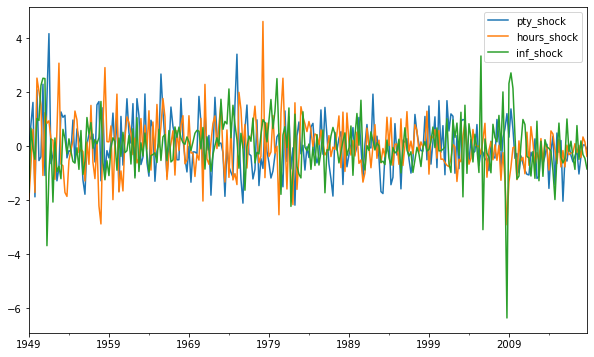

In [21]:
## Look into the structural shocks epsilon
str_shocks_est=pd.DataFrame(epsilon_est.T)
str_shocks_est.index=ts_var1.index[nlags:]
if str_shocks_est.shape[1]==3:
    str_shocks_est.columns=['pty_shock','hours_shock','inf_shock']
if str_shocks_est.shape[1]==2:
    str_shocks_est.columns=['productivity','hours']
str_shocks_est.plot(figsize=(10,6))

In [22]:
## function of bootstrapping var series 
def var_boot(rs, steps):
    """
    Bootstrapping VAR(p) process, given estimated coefficients coefs and reduced residuals u
    
    Parameters
    ----------
    rs :   result from reduced VAR estimate 
    
    sig_u : ndarray
        Covariance matrix of the residuals or innovations.
        If sig_u is None, then an identity matrix is used.
    steps : None or int
        number of observations to simulate, this includes the initial
        observations to start the autoregressive process.
        If offset is not None, then exog of the model are used if they were
        provided in the model
    seed : None or integer
        If seed is not None, then it will be used with for the random
        variables generated by numpy.random.
    Returns
    -------
    data_boot : nd_array
         artificial data from bootstrapping 
    """
    
    k = rs.neqs               # number of variables
    nlags =rs.coefs.shape[0] # number of lags  
    coefs = rs.coefs
    u = np.array(rs.resid)
    intercept = rs.intercept    # (k, )
    nobs = rs.nobs
    ## resampling redisuals with replacement 
    ugen = np.array([np.random.choice(u[:,i], size=steps,replace=True) for i in range(neqs)]).T   # steps x k 

    ##  empty array to be filled 
    result = np.zeros((steps, k))    # steps x k 
    if intercept is not None:
        result += intercept
        result[nlags:] += ugen[nlags:]
    else:
        result[nlags:] = ugen[nlags:]
    
    ygen = np.zeros((steps,k))
    
    for t in range(nlags,steps):
        ygen[t] = result[t]
        for j in range(nlags):
            ygen[t]+=np.dot(coefs[j],ygen[t-j-1])
    return ygen

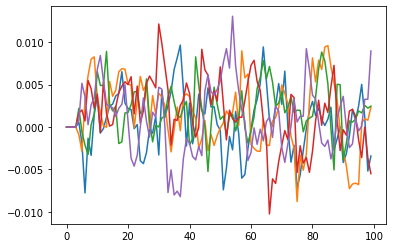

In [23]:
# var_boot does give different samples
plt.figure()
for i in range(5):
    plt.plot(var_boot(rs1,100)[:,1])

In [24]:
## generate confidence bands by bootstrapping 
def sirf_errband_boot(rs, orth=False, repl=1000, T=10, \
                    signif=0.05, burn=10, cum=False):
    """
    Parameters
    ----------
        rs:   result from reduced VAR 
        orth: bool, default False
            Compute orthoganalized impulse response error bands
        repl: int
            number of Monte Carlo replications to perform
        T: int, default 10
            number of impulse response periods
        signif: float (0 < signif <1)
            Significance level for error bars, defaults to 95% CI
        seed: int
            np.random.seed for replications
        burn: int
            number of initial observations to discard for simulation
        cum: bool, default False
            produce cumulative irf error bands
    Returns
    -------
        Tuple of lower and upper arrays of ma_rep monte carlo standard errors
    """
    k = rs.neqs
    coefs = rs.coefs
    sigma_u = rs.sigma_u
    nobs = rs.nobs
    ma_coll = np.zeros((repl, T+1, k, k))
    plt.figure()
    for i in range(repl):
        # discard first hundred to correct for starting bias
        sim = var_boot(rs, steps=nobs + burn)
        sim = sim[burn:]
        sim_var = VAR(sim)
        sim_var_rs = sim_var.fit(4)
        #if i <4:
        #    print(sim_var_rs.aic)   # used to check if each time the reduced VAR gives different results
        sim_svar_rs = SVAR_BQLR(sim_var_rs,T_irf=T)
        sim_B_est = sim_svar_rs['B_est']
        sim_shock_est =sim_svar_rs['eps_est'] 
        sim_irf = sim_svar_rs['irf']
        ma_coll[i] = sim_irf
    ma_sort = np.sort(ma_coll, axis=0)  # sort to get quantiles
    index = (int(round(signif / 2 * repl) - 1),int(round((1 - signif / 2) * repl) - 1))
    lower = ma_sort[index[0], :, :, :]
    upper = ma_sort[index[1], :, :, :]
    
    return lower, upper

In [25]:
sirf_errband_rs = sirf_errband_boot(rs1)

<Figure size 432x288 with 0 Axes>

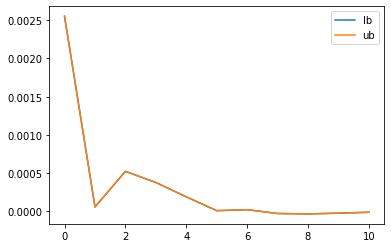

In [26]:
plt.figure()
plt.plot(sirf_errband_rs[0][:,0,0],label='lb')
plt.plot(sirf_errband_rs[1][:,0,0],label='ub')
plt.legend(loc=0)

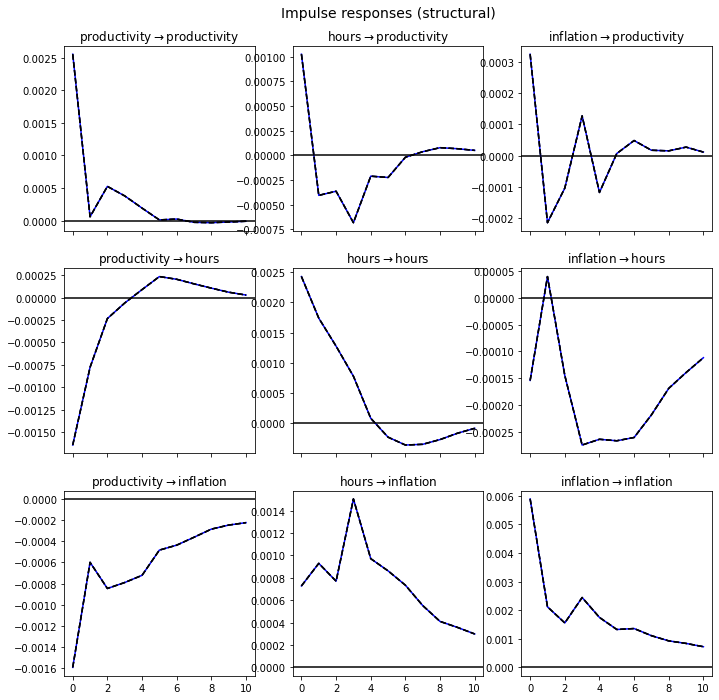

In [27]:
## IR plot parameters prepared 

## svar_ma to impulse respulse parameters

irfs = svar_irf 
stderr = sirf_errband_rs  # T x k x k
impulse = None  # int, the location of shock of interest   
response =  None  # int, the location of variable of response

if neqs==3:
    model_names= np.array(['productivity','hours','inflation'])
if neqs==2:
    model_names= np.array(['productivity','hours'])

title = 'Impulse responses (structural)'
signif =0.20
subplot_params =None
stderr_type ='mc'
plot_params={}

# plot the figure using existing module  
fig = plotting.irf_grid_plot(irfs, stderr, impulse, response,
                                     model_names, title, signif=signif,
                                     subplot_params=subplot_params,
                                     plot_params=plot_params,
                                     stderr_type=stderr_type)

Text(0, 0.5, 'non-technology shocks')

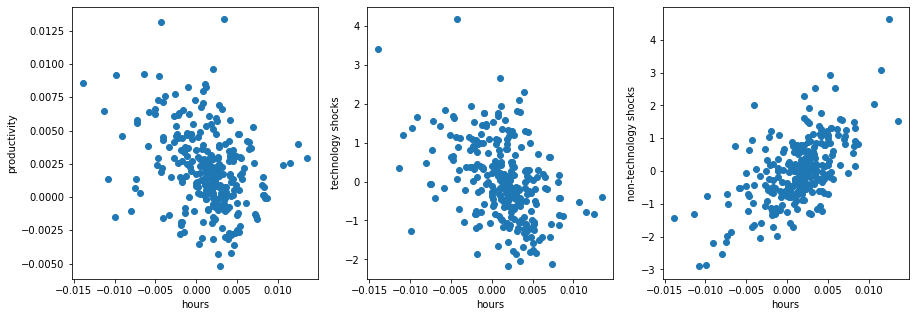

In [28]:
## replicate Gali(1999) figure 1

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(ts_var1.iloc[:,1],ts_var1.iloc[:,0])
plt.xlabel('hours')
plt.ylabel('productivity')

plt.subplot(1,3,2)
plt.scatter(ts_var1.iloc[nlags:,1],str_shocks_est['pty_shock'])
plt.xlabel('hours')
plt.ylabel('technology shocks')

plt.subplot(1,3,3)
plt.scatter(ts_var1.iloc[nlags:,1],str_shocks_est['hours_shock'])
plt.xlabel('hours')
plt.ylabel('non-technology shocks')

In [29]:
#ts_plot1=rs1.plot()

In [30]:
def SVAR_MaxShare(rs,h,pty_id=0,contemp=True):
    """
    inputs
    ------
    rs: result object of reduced VAR estimated using statsmodels.tsa.VAR
    h:  int 
        exogoneous forecast horizon
    pty_id: int
        position index of labor productivity, whose forecast error attributed to tech shock is to be maximized 
    
    outputs
    -------
    dict
      sigma_u: ndarrray
               variance-convariance of reduced VAR residuals
               
      nlags:   int
               number of lags 
               
      residuals: ndarray
               reduced var residuals
               
      alpha_est:   ndarray  k x 1 
               alpha_est = F'e_j where F is otho k x k matrix 
                                 and e_j is the k x 1 matrix that takes one at j-th position
      H:      ndarray
              chol(\Omega^u)
              
      eps_est: ndarray
               estimated structural shocks = alpha' H^{-1} u
      
      shares: ndarray k x 1
              shares of forecast errors of variable i attributed to different shocks 
      ...
    """
    # basic parameters passed down from reduced VAR 
    
    k = rs1.neqs    # number of equations 
    nlags =rs1.coefs.shape[0] # number of lags 
    sigma_u = rs1.sigma_u     # k x k 
    u = np.array(rs1.resid)  # k x 1 
    var_coefs = rs1.coefs   # p x k x k 
    
    # ma representations 
    maxn = h+1           # time horizon for ma representation(infty in theory, finite in practice) 
    ma_mats = ma_rep(var_coefs,maxn)   # D matrix: maxn+1 x k x k 
    
    ## compute forecast errors for horizon h
    fe_mats = np.zeros([k,k])   # k variables,thus k forecast errors  
    
    for t in range(h):
        fe_mats += np.dot(np.dot(ma_mats[t],
                                 sigma_u),
                          ma_mats[t].T)    # \sum_0^{h-1} D_tau \Sigma_u D_tau' 
    #print(fe_mats)
    eye_i = np.zeros([k,1])
    eye_i[pty_id] = 1
    fe = np.dot(np.dot(eye_i.T,
                       fe_mats),
                eye_i)
    
    # equivalent to pre and post multiply it by a selectio matrix e_i where only i-th entry is one
    
    ## estimate H matrix 
    H = LA.cholesky(sigma_u)
    
    def fe_share(alpha):
        """
        inputs
        ------
        alpha: ndarray: k x 1
               alpha = F e_j, where F is an othogonal matrix such that FF'=I
        i: int  the location of the technology shock
        outputs
        ------
        fe_share: share of forecast errors of k variables attributed to shock j 
                ndaray:  k x 1 
        """
        
        fe_contr_mats = np.zeros([k,k]) 
        
        for t in range(h):
            fe_contr_mats += np.dot(np.dot(ma_mats[t],
                                 np.dot(alpha,alpha.T)),
                          ma_mats[t].T) 
        
        fe_contr= np.dot(np.dot(eye_i.T,
                                fe_contr_mats),
                         eye_i)
        #print(fe_contr.shape)
        share = fe_contr/fe    # objective function to maximize in the max-share approach 
        
        return share
    
    ## Estimation of alpha
    
    ### objective function of alpha 
    
    obj = lambda alpha: -fe_share(alpha)
    alpha_init = np.random.rand(k,1)   
    
    
    
    ### constraint on alpha
    
    # the following 3 lines are not necessary 
    #I_k = np.identity(k)
    #e_j = np.zeros([k,1]) 
    #e_j[0] = 1       # used to pick up the j-th column of F
    
    
    def constr_eq1(alpha):
        return np.dot(alpha.T, alpha)-1  # constraint that F is ortho
    
    def constr_eq2(alpha):
        eye_ij = np.zeros([k,1])
        eye_ij[0,0] = 1
        return np.dot(eye_ij.T,alpha)

    ##
    #constr = {'type':'eq', 'fun': constr_eq1}
    constr_lst =[]
    constr_lst.append({'type':'eq', 'fun': constr_eq1})
    
    #if contemp==False:
    #    constr_lst.append( {'type':'eq', 'fun': constr_eq2})
        
    constr = tuple(constr_lst)
    ### maximization  
    alpha_est = minimize(obj,x0=alpha_init,constraints=constr)['x']
    print("Estimated alpha that maximizes the share of forecast error is "+ str(alpha_est))
    
    ## estimatd structural shocks 
    epsilon_est = np.dot(np.dot(alpha_est.T,
                                LA.inv(H)),
                         u.T)

    return {'var_coefs':var_coefs,'sigma_u':sigma_u,'fe':fe,'nlags':nlags, 'neqs': k,\
                'residuals':u,'alpha_est':alpha_est,'epsilon_est':epsilon_est}

In [31]:
## invoke max_share estimation
horizon = 40  #10 years
SVAR_maxshare_rst = SVAR_MaxShare(rs1,horizon)
tech_shock = SVAR_maxshare_rst['epsilon_est'].flatten()
alpha_est = SVAR_maxshare_rst['alpha_est']

Estimated alpha that maximizes the share of forecast error is [ 0.36751829  0.91188293 -0.18275623]


/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_886/794532920.py:130: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  alpha_est = minimize(obj,x0=alpha_init,constraints=constr)['x']


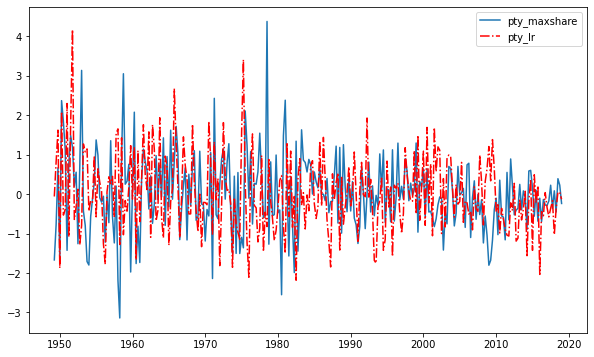

In [32]:
## save it to data frames 
str_shocks_est['pty_max_shock']=tech_shock.T

# compare two tech shocks estimated from different approaches 
plt.figure(figsize=(10,6))
plt.plot(str_shocks_est['pty_max_shock'],label='pty_maxshare')
plt.plot(str_shocks_est['pty_shock'],'r-.',label='pty_lr')
plt.legend(loc=1)

In [33]:
print('The correlation coefficient of tech shocks identified using long-run \
\n restriction and max-share approach is '+ \
      str(round(str_shocks_est['pty_max_shock'].corr(str_shocks_est['pty_shock']),3)))

The correlation coefficient of tech shocks identified using long-run 
 restriction and max-share approach is 0.024


### News shocks by Sims et al.(2014)

The news shock is defined as structural shock that is orthogonal to current productivity but accounts the maximum share of forecast error of productivity in medium horizon. The identification approach is a small variation of max-share approach discussed above. 

The difference is that now there is addional two contraints on the $\alpha$ matrice, both of which together guarantee that the news shock has no contemporaneous effect on productivity. 

Define $$B \gamma = \alpha $$

Then the constraints are 

$$B(1,j) = 0 \quad \forall j>1$$
$$\gamma(1,1)= 0$$

In [34]:
news_shock_rst = SVAR_MaxShare(rs1,horizon,contemp=False)
news_shock = news_shock_rst['epsilon_est'].flatten()
str_shocks_est['news_shock']=news_shock.T

Estimated alpha that maximizes the share of forecast error is [0.15540494 0.34459658 0.92579831]


/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_886/794532920.py:130: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  alpha_est = minimize(obj,x0=alpha_init,constraints=constr)['x']


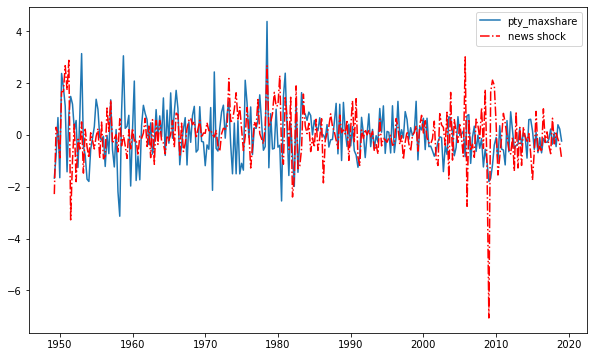

In [35]:
# compare two tech shocks estimated from different approaches 
plt.figure(figsize=(10,6))
plt.plot(str_shocks_est['pty_max_shock'],label='pty_maxshare')
plt.plot(str_shocks_est['news_shock'],'r-.',label='news shock')
plt.legend(loc=1)

In [36]:
print('The correlation coefficient of tech shocks \
identified using max-share approach and the news shock is '+ \
      str(round(str_shocks_est['pty_max_shock'].corr(str_shocks_est['news_shock']),3)))

The correlation coefficient of tech shocks identified using max-share approach and the news shock is 0.202


In [37]:
## merge with oil shock 

str_shocks_est = pd.merge(str_shocks_est,             
                          mps_shockQ,
                         left_index=True,
                         right_index=True,
                         how='outer')

str_shocks_est = pd.merge(str_shocks_est,             
                          os_shockQ,
                         left_index=True,
                         right_index=True,
                         how='outer')

str_shocks_est

,pty_shock,hours_shock,inf_shock,pty_max_shock,news_shock,MP1,ED4,ED8,OPShock_nm
1946-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...
2018-06-30,0.050238,0.344701,-0.307723,0.391485,-0.165757,-0.00442,0.025,0.025,1.396959
2018-09-30,0.043251,0.154456,-0.449851,0.226942,-0.365648,0.01069,0.015,0.015,0.361868
2018-12-31,-0.128852,-0.376158,-0.842077,-0.236259,-0.904822,0.03569,0.020,-0.025,0.000000
2019-03-31,NaN,NaN,NaN,NaN,NaN,0.01409,-0.115,-0.150,0.000000


In [38]:
### save shocks (quarterly)

str_shocks_est.to_stata('../OtherData/InfShocksQ.dta')   # this is the quarterly version as tech shocks is in quarterly